# CNN for RSSI + CSI

In [2]:
import os
print("當前工作目錄:", os.getcwd())
print("這裡有哪些檔案:", os.listdir())
os.chdir('/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN')
print("當前工作目錄:", os.getcwd())

當前工作目錄: /media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN
這裡有哪些檔案: ['best_model_tmp.pth', '__init__.py', 'training_results.txt', 'csidataset.py', 'train.ipynb', 'csi_val_acc.png', 'repeat_copy', 'data_loader.py', 'csi_train_loss.png', 'train_soft_label.ipynb', 'rssicsi_train.ipynb', 'best_csirssi_classifier_bn_temp.pth', 'best_csirssi_reg_temp.pth', 'repeat_for_zero_shot', 'repeat', 'csi_train_acc.png', 'models_save', 'model_save_soft_label', '__pycache__', 'csi_val_loss.png', 'model.py', 'rssicsi_train copy.ipynb', 'train copy.ipynb', 'zero_shot_test.ipynb', 'best_csi_reg_temp.pth', 'train_mirco.ipynb', 'soft_labels.npz']
當前工作目錄: /media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('./')
from csidataset import *
import data_loader
from data_loader import *
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import denoise
from model import *

#   CSI資料載入

In [6]:
csi_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1223_phone/5G/20MHz/csv/all"
rssi_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/RSSI/timestamp_allignment_Balanced_2024_12_14_rtt_logs.csv"

In [7]:
# Load data CSI
reference_points = {}
spacing = 0.6  # 每隔 0.6mh origin

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(csi_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

data, rp_labels, coord_labels = load_data(reference_points)

In [8]:
data

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,919.592301,929.595611,877.760787,898.203763,851.400023,893.573164,888.473973,871.023536,836.316328,841.770753,...,-1.387518,-1.581549,-1.708760,-2.080869,-2.287379,-2.467120,-2.666997,-2.982241,-50.0,136.0
1,698.204841,732.963846,684.079674,694.257877,651.079872,672.521375,687.674342,780.946221,803.560203,863.103702,...,-2.677159,-2.877730,-3.051501,2.738820,2.503722,2.256683,2.035376,1.737005,-49.0,148.0
2,745.268408,768.188128,706.606680,713.252410,681.482208,713.950278,736.619983,852.877482,846.442556,880.032954,...,0.176051,-0.063704,-0.251636,-0.776139,-1.023850,-1.275624,-1.535994,-1.899522,-50.0,224.0
3,830.278267,829.860832,804.005597,796.492310,786.787138,800.870776,791.982323,778.923616,763.872372,766.167084,...,-1.031820,-1.194379,-1.338067,-1.666445,-1.878363,-2.100073,-2.369892,-2.666982,-51.0,136.0
4,906.099884,903.507056,910.843565,896.688352,892.235955,875.416472,878.300632,854.687077,857.886939,843.664033,...,-0.445534,-0.593750,-0.783166,-1.090942,-1.286103,-1.497279,-1.784787,-2.076610,-50.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24495,397.615392,416.889674,395.588170,413.019370,382.733589,381.136459,393.814677,434.337426,465.842248,483.735465,...,2.183710,2.005190,1.826107,1.364322,1.150287,0.872978,0.573063,0.255977,-56.0,148.0
24496,643.708785,646.260010,627.624888,621.498994,605.152873,628.458431,617.272225,592.763865,581.986254,587.911558,...,-0.494557,-0.782703,-1.053078,-1.631902,-1.969954,-2.328378,-2.758960,3.087458,-59.0,136.0
24497,762.685387,745.553486,706.884007,695.708272,698.951357,710.169698,720.184004,675.370269,654.120020,669.209982,...,0.621717,0.498336,0.356470,-0.131807,-0.426306,-0.748795,-1.031706,-1.339351,-58.0,136.0
24498,401.220638,416.688133,388.561449,390.436935,370.411933,382.498366,394.452786,436.664631,446.643034,495.258518,...,-1.801749,-2.120022,-2.410138,3.138034,2.751942,2.306627,1.868269,1.432071,-56.0,148.0


In [17]:
import numpy as np
import pandas as pd

target_count = 401
unique_labels = np.unique(rp_labels)

filtered_data = []
filtered_rp_labels = []
filtered_coord_labels = []

for label in unique_labels:
    indices = np.where(rp_labels == label)[0]

    if len(indices) < target_count:
        print(f"Label {label} only has {len(indices)} samples, skipped.")
        continue

    selected_indices = indices[:target_count]  # ✅ 固定取最前面的 401 筆

    filtered_data.append(data.iloc[selected_indices])
    filtered_rp_labels.append(rp_labels[selected_indices])
    filtered_coord_labels.append(coord_labels.iloc[selected_indices])

# ✅ 合併，確保型別一致
data_filtered = pd.concat(filtered_data, ignore_index=True)  # DataFrame
rp_labels_filtered = np.concatenate(filtered_rp_labels, axis=0)  # ndarray
coord_labels_filtered = pd.concat(filtered_coord_labels, ignore_index=True)  # DataFrame

# ✅ 驗證
print("✅ 合併後資料型別：")
print("data_filtered:", type(data_filtered), data_filtered.shape)
print("rp_labels_filtered:", type(rp_labels_filtered), rp_labels_filtered.shape)
print("coord_labels_filtered:", type(coord_labels_filtered), coord_labels_filtered.shape)

print("\n每個 label 筆數（應該都為 401）：")
print(pd.Series(rp_labels_filtered).value_counts().sort_index())

✅ 合併後資料型別：
data_filtered: <class 'pandas.core.frame.DataFrame'> (19649, 99)
rp_labels_filtered: <class 'numpy.ndarray'> (19649,)
coord_labels_filtered: <class 'pandas.core.frame.DataFrame'> (19649, 2)

每個 label 筆數（應該都為 401）：
1     401
2     401
3     401
4     401
5     401
6     401
7     401
8     401
9     401
10    401
11    401
12    401
13    401
14    401
15    401
16    401
17    401
18    401
19    401
20    401
21    401
22    401
23    401
24    401
25    401
26    401
27    401
28    401
29    401
30    401
31    401
32    401
33    401
34    401
35    401
36    401
37    401
38    401
39    401
40    401
41    401
42    401
43    401
44    401
45    401
46    401
47    401
48    401
49    401
Name: count, dtype: int64


In [18]:
data_filtered

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,Label
0,919.592301,929.595611,877.760787,898.203763,851.400023,893.573164,888.473973,871.023536,836.316328,841.770753,...,-1.581549,-1.708760,-2.080869,-2.287379,-2.467120,-2.666997,-2.982241,-50.0,136.0,1
1,698.204841,732.963846,684.079674,694.257877,651.079872,672.521375,687.674342,780.946221,803.560203,863.103702,...,-2.877730,-3.051501,2.738820,2.503722,2.256683,2.035376,1.737005,-49.0,148.0,1
2,745.268408,768.188128,706.606680,713.252410,681.482208,713.950278,736.619983,852.877482,846.442556,880.032954,...,-0.063704,-0.251636,-0.776139,-1.023850,-1.275624,-1.535994,-1.899522,-50.0,224.0,1
3,830.278267,829.860832,804.005597,796.492310,786.787138,800.870776,791.982323,778.923616,763.872372,766.167084,...,-1.194379,-1.338067,-1.666445,-1.878363,-2.100073,-2.369892,-2.666982,-51.0,136.0,1
4,906.099884,903.507056,910.843565,896.688352,892.235955,875.416472,878.300632,854.687077,857.886939,843.664033,...,-0.593750,-0.783166,-1.090942,-1.286103,-1.497279,-1.784787,-2.076610,-50.0,136.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19644,381.980366,398.527289,370.951479,372.108855,352.346420,359.233907,370.000000,413.997585,420.138073,454.862617,...,-0.668036,-0.872238,-1.396551,-1.667962,-1.977215,-2.212040,-2.563840,-56.0,148.0,49
19645,737.651679,730.928861,707.471554,673.190909,665.090219,689.385233,679.574131,666.066813,646.891026,636.792745,...,0.417030,0.233346,-0.227937,-0.474118,-0.747335,-1.038664,-1.386254,-58.0,136.0,49
19646,364.329521,391.318285,383.775976,384.610192,367.828765,339.330223,346.236913,376.766506,421.283752,448.486343,...,-1.877905,2.906870,1.246783,0.451070,-0.370119,-1.260481,-2.098871,-57.0,148.0,49
19647,396.021464,409.890229,392.439804,391.154701,374.786606,380.443163,384.193961,434.991954,450.813709,472.956658,...,1.488145,1.336005,0.979841,0.765983,0.532844,0.208257,-0.127813,-58.0,224.0,49


In [16]:
import numpy as np
import pandas as pd

target_count = 401
unique_labels = csi["Label"].unique()

filtered_csi_parts = []

for label in unique_labels:
    group = csi[csi["Label"] == label]
    if len(group) < target_count:
        print(f"Label {label} only has {len(group)} samples, skipped.")
        continue
    filtered = group.iloc[:target_count]  # ✅ 固定取最前面 401 筆
    filtered_csi_parts.append(filtered)

# ✅ 合併
csi_filtered = pd.concat(filtered_csi_parts, ignore_index=True)

# ✅ 驗證
print("✅ csi_filtered shape:", csi_filtered.shape)
print("每個 Label 的筆數（應該都為 401）：")
print(csi_filtered["Label"].value_counts().sort_index())



✅ csi_filtered shape: (19649, 99)
每個 Label 的筆數（應該都為 401）：
Label
1     401
2     401
3     401
4     401
5     401
6     401
7     401
8     401
9     401
10    401
11    401
12    401
13    401
14    401
15    401
16    401
17    401
18    401
19    401
20    401
21    401
22    401
23    401
24    401
25    401
26    401
27    401
28    401
29    401
30    401
31    401
32    401
33    401
34    401
35    401
36    401
37    401
38    401
39    401
40    401
41    401
42    401
43    401
44    401
45    401
46    401
47    401
48    401
49    401
Name: count, dtype: int64


In [19]:
# Load data RSSI

label_to_coordinates_swapped = {
    "1-1":  (0, 0),   "1-2":  (0, 0.6),   "1-3":  (0, 1.2),   "1-4":  (0, 1.8),
    "1-5":  (0, 2.4), "1-6":  (0, 3.0),   "1-7":  (0, 3.6),   "1-8":  (0, 4.2),
    "1-9":  (0, 4.8), "1-10": (0, 5.4),   "1-11": (0, 6.0),

    "2-1":  (0.6, 0),  "2-11": (0.6, 6.0),

    "3-1":  (1.2, 0),  "3-11": (1.2, 6.0),

    "4-1":  (1.8, 0),  "4-11": (1.8, 6.0),

    "5-1":  (2.4, 0),  "5-11": (2.4, 6.0),

    "6-1":  (3.0, 0),  "6-2":  (3.0, 0.6),  "6-3":  (3.0, 1.2),  "6-4":  (3.0, 1.8),
    "6-5":  (3.0, 2.4), "6-6":  (3.0, 3.0),  "6-7":  (3.0, 3.6),  "6-8":  (3.0, 4.2),
    "6-9":  (3.0, 4.8), "6-10": (3.0, 5.4),  "6-11": (3.0, 6.0),

    "7-1":  (3.6, 0),  "7-11": (3.6, 6.0),

    "8-1":  (4.2, 0),  "8-11": (4.2, 6.0),

    "9-1":  (4.8, 0),  "9-11": (4.8, 6.0),

    "10-1": (5.4, 0),  "10-11": (5.4, 6.0),

    "11-1": (6.0, 0),  "11-2": (6.0, 0.6), "11-3": (6.0, 1.2), "11-4": (6.0, 1.8),
    "11-5": (6.0, 2.4),"11-6": (6.0, 3.0), "11-7": (6.0, 3.6), "11-8": (6.0, 4.2),
    "11-9": (6.0, 4.8),"11-10":(6.0, 5.4), "11-11":(6.0, 6.0)
}


coordinates = {
        1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
        36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
        2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
        6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
        12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
        16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
        20: (5.4, 6.0), 21: (6.0, 6.0),
        22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
        26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
        41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
        44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
        47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
    }
coordinate_to_label2 = {value: key for key, value in coordinates.items()}

# label_to_coordinates:  "1-1" -> (0, 0)
# coordinates:          1      -> (0, 0)

# 1) 先建立一個「座標 -> 數字」的反轉字典
coord_to_num = {value: key for key, value in coordinates.items()}
# coord_to_num[(0,0)] = 1,  coord_to_num[(0.6,0)] = 40, ...

# 2) 建立 "1-1" -> 整數標籤 的 map
label_str_to_num = {}
for str_label, coord in label_to_coordinates_swapped.items():
    if coord in coord_to_num:  # 確保在座標字典中找得到
        label_str_to_num[str_label] = coord_to_num[coord]

In [20]:
rssi = pd.read_csv(rssi_path)

rssi = rssi.drop(columns=['timeStemp', 'AP1_Distance (mm)', 'AP2_Distance (mm)', 'AP3_Distance (mm)', 'AP4_Distance (mm)', 'AP1_StdDev (mm)','AP2_StdDev (mm)', 'AP3_StdDev (mm)', 'AP4_StdDev (mm)'])

In [21]:
rssi["Label"]

0        1-11
1        1-11
2        1-11
3        1-11
4        1-11
         ... 
19644     7-1
19645     7-1
19646     7-1
19647     7-1
19648     7-1
Name: Label, Length: 19649, dtype: object

In [22]:
rssi["Label"] = (
    rssi["Label"]
    .map(label_to_coordinates_swapped)   # 由 "1-1" → (0,0)
    .map(coordinate_to_label2)   # 由 (0,0) → 1 (或其他整數標籤)
)


In [23]:
rssi

,Label,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,11,-60.0,-68.0,-61.0,-59.0
1,11,-62.0,-70.0,-59.0,-59.0
2,11,-61.0,-69.0,-62.0,-55.0
3,11,-62.0,-69.0,-63.0,-55.0
4,11,-61.0,-70.0,-62.0,-55.0
...,...,...,...,...,...
19644,35,-64.0,-66.0,-61.0,-58.0
19645,35,-67.0,-75.0,-62.0,-59.0
19646,35,-64.0,-66.0,-61.0,-57.0
19647,35,-66.0,-65.0,-59.0,-58.0


In [25]:
import pandas as pd

target_count = 401
filtered_rssi_parts = []

for label in rssi["Label"].unique():
    group = rssi[rssi["Label"] == label]
    if len(group) >= target_count:
        filtered = group.iloc[:target_count]  # 固定取前 401 筆
        filtered_rssi_parts.append(filtered)
    else:
        print(f"Label {label} 只有 {len(group)} 筆，不足 {target_count} 筆，略過")

# 合併所有符合條件的 group
rssi_filtered = pd.concat(filtered_rssi_parts, ignore_index=True)

print("✅ rssi_filtered shape:", rssi_filtered.shape)
print("各 Label 筆數（應該都為 401）：")
print(rssi_filtered["Label"].value_counts().sort_index())



✅ rssi_filtered shape: (19649, 5)
各 Label 筆數（應該都為 401）：
Label
1     401
2     401
3     401
4     401
5     401
6     401
7     401
8     401
9     401
10    401
11    401
12    401
13    401
14    401
15    401
16    401
17    401
18    401
19    401
20    401
21    401
22    401
23    401
24    401
25    401
26    401
27    401
28    401
29    401
30    401
31    401
32    401
33    401
34    401
35    401
36    401
37    401
38    401
39    401
40    401
41    401
42    401
43    401
44    401
45    401
46    401
47    401
48    401
49    401
Name: count, dtype: int64


In [28]:
import pandas as pd

def safe_label_merge(data_filtered, rssi_filtered):
    # 防呆檢查欄位
    if "Label" not in data_filtered.columns or "Label" not in rssi_filtered.columns:
        raise ValueError("兩個 DataFrame 都必須包含 'Label' 欄位")

    # 防呆檢查每個 Label 的筆數
    label_counts_data = data_filtered["Label"].value_counts().sort_index()
    label_counts_rssi = rssi_filtered["Label"].value_counts().sort_index()

    if not label_counts_data.equals(label_counts_rssi):
        print("❌ Label 筆數不一致：")
        print("data_filtered:\n", label_counts_data)
        print("rssi_filtered:\n", label_counts_rssi)
        raise ValueError("每個 Label 的筆數在兩個資料集之間不一致")

    # 加入 group-wise index：0~400 每組
    def add_group_index(df):
        return df.groupby("Label", group_keys=False).apply(lambda x: x.reset_index(drop=True))

    data_sorted = add_group_index(data_filtered.copy())
    rssi_sorted = add_group_index(rssi_filtered.copy())

    # 防呆檢查 Label 是否完全一樣 & 順序一致
    if not (data_sorted["Label"].values == rssi_sorted["Label"].values).all():
        raise ValueError("兩個資料集的 Label 值或順序不一致，無法安全合併")

    # 移除 rssi 裡的 Label 欄位，避免重複
    rssi_only = rssi_sorted.drop(columns=["Label"])

    # 合併
    combined = pd.concat([data_sorted.reset_index(drop=True), rssi_only.reset_index(drop=True)], axis=1)

    print("✅ 合併成功，總筆數：", combined.shape[0], "，欄位數：", combined.shape[1])
    return combined
combined = safe_label_merge(data_filtered, rssi_filtered)


✅ 合併成功，總筆數： 19649 ，欄位數： 103


/tmp/ipykernel_2600420/471310652.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("Label", group_keys=False).apply(lambda x: x.reset_index(drop=True))
/tmp/ipykernel_2600420/471310652.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("Label", group_keys=False).apply(lambda x: x.reset_index(drop=True))


In [29]:
combined

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,Label,AP1_Rssi,AP2_Rssi,AP3_Rssi,AP4_Rssi
0,919.592301,929.595611,877.760787,898.203763,851.400023,893.573164,888.473973,871.023536,836.316328,841.770753,...,-2.467120,-2.666997,-2.982241,-50.0,136.0,1,-62.0,-72.0,-65.0,-54.0
1,698.204841,732.963846,684.079674,694.257877,651.079872,672.521375,687.674342,780.946221,803.560203,863.103702,...,2.256683,2.035376,1.737005,-49.0,148.0,1,-61.0,-73.0,-66.0,-56.0
2,745.268408,768.188128,706.606680,713.252410,681.482208,713.950278,736.619983,852.877482,846.442556,880.032954,...,-1.275624,-1.535994,-1.899522,-50.0,224.0,1,-62.0,-72.0,-66.0,-55.0
3,830.278267,829.860832,804.005597,796.492310,786.787138,800.870776,791.982323,778.923616,763.872372,766.167084,...,-2.100073,-2.369892,-2.666982,-51.0,136.0,1,-61.0,-73.0,-66.0,-55.0
4,906.099884,903.507056,910.843565,896.688352,892.235955,875.416472,878.300632,854.687077,857.886939,843.664033,...,-1.497279,-1.784787,-2.076610,-50.0,136.0,1,-54.0,-72.0,-67.0,-55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19644,381.980366,398.527289,370.951479,372.108855,352.346420,359.233907,370.000000,413.997585,420.138073,454.862617,...,-1.977215,-2.212040,-2.563840,-56.0,148.0,49,-54.0,-65.0,-53.0,-57.0
19645,737.651679,730.928861,707.471554,673.190909,665.090219,689.385233,679.574131,666.066813,646.891026,636.792745,...,-0.747335,-1.038664,-1.386254,-58.0,136.0,49,-53.0,-64.0,-55.0,-59.0
19646,364.329521,391.318285,383.775976,384.610192,367.828765,339.330223,346.236913,376.766506,421.283752,448.486343,...,-0.370119,-1.260481,-2.098871,-57.0,148.0,49,-45.0,-64.0,-54.0,-59.0
19647,396.021464,409.890229,392.439804,391.154701,374.786606,380.443163,384.193961,434.991954,450.813709,472.956658,...,0.532844,0.208257,-0.127813,-58.0,224.0,49,-54.0,-64.0,-55.0,-59.0


In [31]:
columns_to_keep = list(range(48)) + ["Label", "AP1_Rssi", "AP2_Rssi", "AP3_Rssi", "AP4_Rssi"]
combined_slim = combined[columns_to_keep]

print("✅ 精簡後的 combined_slim：", combined_slim.shape)
print(combined_slim.head())



✅ 精簡後的 combined_slim： (19649, 53)
            0           1           2           3           4           5  \
0  919.592301  929.595611  877.760787  898.203763  851.400023  893.573164   
1  698.204841  732.963846  684.079674  694.257877  651.079872  672.521375   
2  745.268408  768.188128  706.606680  713.252410  681.482208  713.950278   
3  830.278267  829.860832  804.005597  796.492310  786.787138  800.870776   
4  906.099884  903.507056  910.843565  896.688352  892.235955  875.416472   

            6           7           8           9  ...          43  \
0  888.473973  871.023536  836.316328  841.770753  ...  587.824804   
1  687.674342  780.946221  803.560203  863.103702  ...  433.706122   
2  736.619983  852.877482  846.442556  880.032954  ...  458.224836   
3  791.982323  778.923616  763.872372  766.167084  ...  544.488751   
4  878.300632  854.687077  857.886939  843.664033  ...  634.679447   

           44          45          46          47  Label  AP1_Rssi  AP2_Rssi  \
0 

## Data Generator

In [32]:
rp_labels = combined['Label']

# 移除 Label 和 RSSI 欄位，只留下 CSI 數據
csi = combined.drop(columns=['Label', 'AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi'])

# 取前 48 欄當作 amplitude（如果這是你定義的）
amp = combined.iloc[:, :48]

# 取出 RSSI 四個欄位
rssi = combined[['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi']]


In [34]:
print("csi shape:", rssi.shape)
print("amp shape:", amp.shape)

csi shape: (19649, 4)
amp shape: (19649, 48)


In [38]:
# 選擇要保留的欄位
columns_to_keep = list(range(48)) + ['AP1_Rssi', 'AP2_Rssi', 'AP3_Rssi', 'AP4_Rssi', 'Label']

# 建立精簡資料集
combined_slim = combined[columns_to_keep]

# 儲存
save_path_slim = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/rssi/combined_csi_rssi_slim.csv"
combined_slim.to_csv(save_path_slim, index=False)
print(f"✅ 精簡資料集已儲存至：{save_path_slim}")


✅ 精簡資料集已儲存至：/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/rssi/combined_csi_rssi_slim.csv


In [36]:
save_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/rssi/combined_csi_rssi_dataset.csv"  # 可自行改路徑
combined.to_csv(save_path, index=False)
print(f"✅ 資料集已儲存至：{save_path}")



✅ 資料集已儲存至：/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/rssi/combined_csi_rssi_dataset.csv


# main

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 路徑
load_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/rssi/combined_csi_rssi_slim.csv"

# 讀取資料
df = pd.read_csv(load_path)
print("✅ 讀取成功，資料維度：", df.shape)

# 針對 RSSI 欄補 0
rssi_cols = ["AP1_Rssi", "AP2_Rssi", "AP3_Rssi", "AP4_Rssi"]
df[rssi_cols] = df[rssi_cols].fillna(0)

# 檢查有沒有補乾淨
print("補完 NaN 之後，還有 NaN 嗎？", df[rssi_cols].isnull().sum().sum())  # 應為 0
print("------------------")

# 保留 index 方便對照
df["orig_index"] = df.index

# 特徵分割
amp = df.iloc[:, 0:48].values
rssi = df[rssi_cols].values
labels = df["Label"].values
orig_idx = df["orig_index"].values

# 切 train / temp
amp_train, amp_temp, rssi_train, rssi_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    amp, rssi, labels, orig_idx, test_size=0.3, random_state=42
)

# 切 val / test
amp_val, amp_test, rssi_val, rssi_test, y_val, y_test, idx_val, idx_test = train_test_split(
    amp_temp, rssi_temp, y_temp, idx_temp, test_size=1/3, random_state=42
)

# 檢查一筆對不對齊
i = 0
print("✅ [amp] 切出來：", amp_train[i][:5])
print("✅ [amp] 原始 df：", df.iloc[int(idx_train[i]), 0:5].values)

print("✅ [rssi] 切出來：", rssi_train[i])
print("✅ [rssi] 原始 df：", df.iloc[int(idx_train[i])][rssi_cols].values)

print("✅ [label] 切出來：", y_train[i])
print("✅ [label] 原始 df：", df.iloc[int(idx_train[i])]["Label"])


✅ 讀取成功，資料維度： (19649, 53)
補完 NaN 之後，還有 NaN 嗎？ 0
------------------
✅ [amp] 切出來： [610.26223871 613.77520315 619.31332942 619.26569419 605.18592185]
✅ [amp] 原始 df： [610.26223871 613.77520315 619.31332942 619.26569419 605.18592185]
✅ [rssi] 切出來： [-62. -69. -64. -53.]
✅ [rssi] 原始 df： [-62. -69. -64. -53.]
✅ [label] 切出來： 4
✅ [label] 原始 df： 4.0


In [90]:
print(amp_train.shape)
print(rssi_train.shape)
print(amp_val.shape)
print(rssi_val.shape)
print(amp_test.shape)
print(rssi_test.shape)

(13754, 48)
(13754, 4)
(3930, 48)
(3930, 4)
(1965, 48)
(1965, 4)


In [91]:
amp_test

array([[275.11815643, 270.20177646, 240.10206163, ..., 402.15046935,
        410.60077935, 379.40084344],
       [270.8671261 , 292.54914117, 277.22193275, ..., 316.07752214,
        326.38627422, 308.18500937],
       [488.18131877, 514.4171459 , 482.28000166, ..., 112.29425631,
        122.58874337, 116.92732786],
       ...,
       [412.00121359, 422.47011729, 408.88629226, ..., 461.49431199,
        471.78172919, 442.92211505],
       [512.44511901, 531.16099254, 488.19053657, ..., 408.04411526,
        443.66766842, 432.08911118],
       [625.51898452, 612.95105841, 599.35381871, ..., 629.05961562,
        631.14182241, 606.79238624]])

In [92]:
print("amp_train shape:", amp_train.shape)


amp_train shape: (13754, 48)


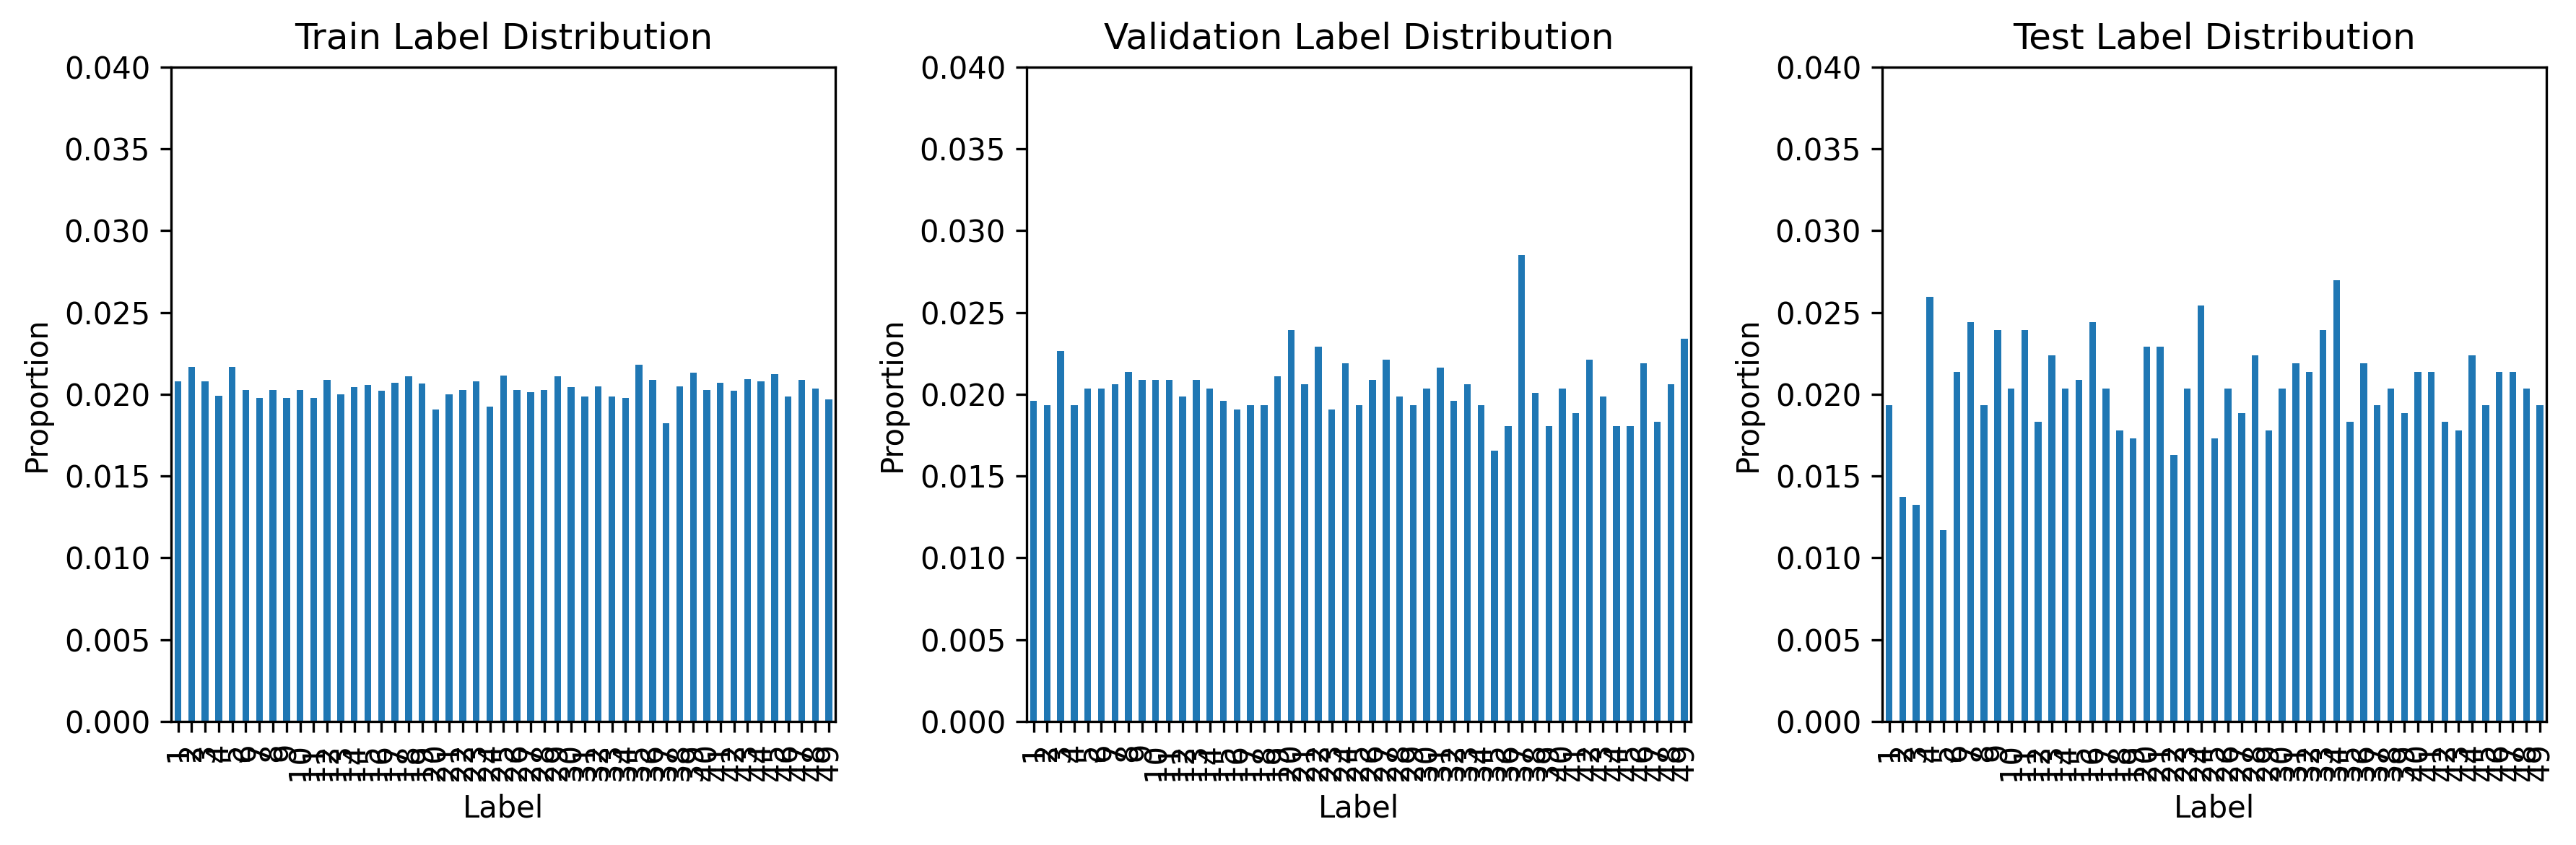

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# 將 y_train, y_val, y_test 轉為 Series（如果尚未轉換）
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)
y_test_series = pd.Series(y_test)

# 設定畫圖樣式與解析度
plt.figure(figsize=(12, 4), dpi=300)

# 畫三張子圖
for i, (data, title) in enumerate([
    (y_train_series, "Train Label Distribution"),
    (y_val_series, "Validation Label Distribution"),
    (y_test_series, "Test Label Distribution")
]):
    plt.subplot(1, 3, i + 1)
    vc_prop = data.value_counts(normalize=True).sort_index()
    ax = vc_prop.plot(kind='bar')
    ax.set_ylim([0, 0.04])  # 可依據實際數據微調
    ax.set_title(title)
    ax.set_xlabel('Label')
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()





In [94]:
encoder = OneHotEncoder(sparse_output=False)
y_train_oh = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_oh = encoder.transform(np.array(y_val).reshape(-1, 1))
y_test_oh = encoder.transform(np.array(y_test).reshape(-1, 1))

In [95]:
print("y_train_oh shape:", y_train_oh.shape)
print("y_val_oh shape:", y_val_oh.shape)
print("y_test_oh shape:", y_test_oh.shape)

y_train_oh shape: (13754, 49)
y_val_oh shape: (3930, 49)
y_test_oh shape: (1965, 49)


In [96]:
# 創建 Dataset 和 DataLoader

batch_size = 32

train_dataset = CSIRSSIDataset(np.array(amp_train), np.array(rssi_train), y_train_oh, augment=True, csi_noise_std=0.00, rssi_mask_prob=0.05)
val_dataset = CSIRSSIDataset(np.array(amp_val),np.array(rssi_val), y_val_oh)
test_dataset = CSIRSSIDataset(np.array(amp_test), np.array(rssi_test), y_test_oh)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [97]:
print("測試資料數量：", len(test_loader.dataset))

測試資料數量： 1965


In [98]:
for amp_inputs, rssi_inputs, labels in train_loader:
        print(labels)




tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ...

# 重複測試

In [99]:
import os
print("當前工作目錄:", os.getcwd())
print("這裡有哪些檔案:", os.listdir())
#os.chdir('/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN')
print("當前工作目錄:", os.getcwd())

當前工作目錄: /media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN
這裡有哪些檔案: ['best_model_tmp.pth', '__init__.py', 'training_results.txt', 'csidataset.py', 'train.ipynb', 'csi_val_acc.png', 'repeat_copy', 'data_loader.py', 'csi_train_loss.png', 'train_soft_label.ipynb', 'rssicsi_train.ipynb', 'best_csirssi_classifier_bn_temp.pth', 'best_csirssi_reg_temp.pth', 'repeat_for_zero_shot', 'repeat', 'csi_train_acc.png', 'models_save', 'model_save_soft_label', '__pycache__', 'csi_val_loss.png', 'model.py', 'rssicsi_train copy.ipynb', 'train copy.ipynb', 'zero_shot_test.ipynb', 'best_csi_reg_temp.pth', 'train_mirco.ipynb', 'soft_labels.npz']
當前工作目錄: /media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/model_CNN


# +BN

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import os

# 假設模型已經定義好
class CSIRSSI_Classifier_BN(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSI_Classifier_BN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten_dim = 128 * 12
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)

        self.fc_rssi1 = nn.Linear(rssi_dim, 128)
        self.bn_rssi1 = nn.BatchNorm1d(128)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(128, 32)
        self.bn_rssi2 = nn.BatchNorm1d(32)
        self.dropout_rssi2 = nn.Dropout(0.5)

        self.fc_fusion = nn.Linear(64 + 32, 64)
        self.dropout_fusion = nn.Dropout(0.3)
        self.fc_class = nn.Linear(64, num_classes)

    def forward(self, csi_input, rssi_input):
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        csi_feat = F.relu(self.fc2(x))
        csi_feat = self.dropout2(csi_feat)

        rssi_feat = F.relu(self.bn_rssi1(self.fc_rssi1(rssi_input)))
        rssi_feat = self.dropout_rssi1(rssi_feat)
        rssi_feat = F.relu(self.bn_rssi2(self.fc_rssi2(rssi_feat)))
        rssi_feat = self.dropout_rssi2(rssi_feat)

        fusion = torch.cat([csi_feat, rssi_feat], dim=1)
        fusion = F.relu(self.fc_fusion(fusion))
        fusion = self.dropout_fusion(fusion)

        class_out = self.fc_class(fusion)
        return class_out

    
    def extract_embedding(self, csi_input, rssi_input):
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        csi_feat = F.relu(self.fc2(x))
        rssi_feat = F.relu(self.bn_rssi1(self.fc_rssi1(rssi_input)))
        rssi_feat = F.relu(self.bn_rssi2(self.fc_rssi2(rssi_feat)))
        fusion = torch.cat([csi_feat, rssi_feat], dim=1)
        fusion = F.relu(self.fc_fusion(fusion))
        return fusion




In [ ]:
#+best

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import copy

# ===== 你的模型 CSIRSSI_Classifier_BN 定義在這裡（略） =====

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_mean_distance_error(y_true, y_pred, coordinates):
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label not in coordinates or pred_label not in coordinates:
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors), errors

COORDINATES = {
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4), 6: (0, 3.0),
    7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0), 22: (6.0, 5.4), 23: (6.0, 4.8),
    24: (6.0, 4.2), 25: (6.0, 3.6), 26: (6.0, 3.0), 27: (6.0, 2.4),
    28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8), 44: (3.0, 2.4),
    45: (3.0, 3.0), 46: (3.0, 3.6), 47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)

num_runs = 5
epochs = 200
patience = 20

test_accs = []
test_mdes = []
all_run_errors = []

for run in range(1, num_runs + 1):
    print(f"\n=== Run {run}/{num_runs} ===")

    model = CSIRSSI_Classifier_BN(num_classes=49).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
    criterion_cls = nn.CrossEntropyLoss()
    best_val_loss = None
    best_state_dict = None
    counter = 0

    for epoch in range(epochs):
        model.train()
        for csi_inputs, rssi_inputs, labels in train_loader:
            csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
            target_class = torch.argmax(labels, dim=1)

            optimizer.zero_grad()
            class_out = model(csi_inputs, rssi_inputs)
            loss = criterion_cls(class_out, target_class)
            loss.backward()
            optimizer.step()

        # 驗證
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for csi_inputs, rssi_inputs, labels in val_loader:
                csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                class_out = model(csi_inputs, rssi_inputs)
                val_loss += criterion_cls(class_out, target_class).item() * csi_inputs.size(0)
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        # 印出 val_loss
        print(f"Run {run}, Epoch {epoch+1}, val_loss = {val_loss:.6f}")

        if (best_val_loss is None) or (val_loss < best_val_loss):
            best_val_loss = val_loss
            counter = 0
            best_state_dict = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                break

    # 測試
    if best_state_dict is None:
        raise RuntimeError("No best_state_dict found. Check training loop or data.")
    model.load_state_dict(best_state_dict)
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for csi_inputs, rssi_inputs, labels in test_loader:
            csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
            target_class = torch.argmax(labels, dim=1)
            class_out = model(csi_inputs, rssi_inputs)
            pred = torch.argmax(class_out, dim=1)
            all_pred.extend(pred.cpu().numpy())
            all_true.extend(target_class.cpu().numpy())

    y_true = np.array(all_true) + 1
    y_pred = np.array(all_pred) + 1
    acc = 100 * np.mean(y_true == y_pred)
    mde, errors = compute_mean_distance_error(y_true, y_pred, COORDINATES)

    test_accs.append(acc)
    test_mdes.append(mde)
    all_run_errors.append(errors)
    print(f"✅ Run {run}: Acc = {acc:.2f}%, MDE = {mde:.4f}")

# 儲存 summary 結果
df = pd.DataFrame({
    "run": list(range(1, num_runs+1)),
    "accuracy": test_accs,
    "mde": test_mdes
})
os.makedirs("repeat_copy/00", exist_ok=True)
df.to_csv("repeat_copy/00/csirssi_cls_results00_error2_b_2.csv", index=False)
print("📁 Results saved to repeat_copy/00/csirssi_cls_results00_error2_b.csv")

# 儲存所有 error（長條格式）
error_records = []
for run_idx, errors in enumerate(all_run_errors):
    for sample_idx, e in enumerate(errors):
        error_records.append({
            "run": run_idx + 1,
            "sample_idx": sample_idx + 1,
            "error": e
        })
df_errors = pd.DataFrame(error_records)
df_errors.to_csv("repeat_copy/00/csirssi_cls_all_errors2_00_b_2.csv", index=False)
print("📁 All errors saved to repeat_copy/00/csirssi_cls_all_errors2_00_b.csv")



=== Run 1/5 ===
Run 1, Epoch 1, val_loss = 0.678859
Run 1, Epoch 2, val_loss = 0.170541
Run 1, Epoch 3, val_loss = 0.095648
Run 1, Epoch 4, val_loss = 0.065961
Run 1, Epoch 5, val_loss = 0.073683
Run 1, Epoch 6, val_loss = 0.055937
Run 1, Epoch 7, val_loss = 0.043618
Run 1, Epoch 8, val_loss = 0.028258
Run 1, Epoch 9, val_loss = 0.028968
Run 1, Epoch 10, val_loss = 0.023270
Run 1, Epoch 11, val_loss = 0.021583
Run 1, Epoch 12, val_loss = 0.023642
Run 1, Epoch 13, val_loss = 0.022980
Run 1, Epoch 14, val_loss = 0.026863
Run 1, Epoch 15, val_loss = 0.041865
Run 1, Epoch 16, val_loss = 0.031126
Run 1, Epoch 17, val_loss = 0.015364
Run 1, Epoch 18, val_loss = 0.022832
Run 1, Epoch 19, val_loss = 0.018353
Run 1, Epoch 20, val_loss = 0.025645
Run 1, Epoch 21, val_loss = 0.019921
Run 1, Epoch 22, val_loss = 0.026924
Run 1, Epoch 23, val_loss = 0.017053
Run 1, Epoch 24, val_loss = 0.016713
Run 1, Epoch 25, val_loss = 0.015505
Run 1, Epoch 26, val_loss = 0.023583
Run 1, Epoch 27, val_loss = 0.

In [ ]:
## 存ERROR版本

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary  # torchinfo 可用來顯示多輸入模型摘要
import matplotlib.pyplot as plt

# -----------------------
# 模型定義：CSIRSSI_DualHead
# -----------------------
class CSIRSSI_DualHead_BN(nn.Module):
    def __init__(self, num_classes=49, rssi_dim=4):
        super(CSIRSSI_DualHead_BN, self).__init__()
        # ---- CSI 分支 (CNN) ---
        # 假設輸入 CSI shape 為 (batch, 1, 48)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # 輸入長度 48 → 經過兩次 pooling → 48/2=24，再 24/2=12
        self.flatten_dim = 128 * 12
        
        self.fc1   = nn.Linear(self.flatten_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2   = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        # 此時 CSI 分支輸出 64 維特徵
        
        # ---- RSSI 分支 (MLP) ----
        self.fc_rssi1 = nn.Linear(rssi_dim, 128)
        self.bn_rssi1 = nn.BatchNorm1d(128)
        self.dropout_rssi1 = nn.Dropout(0.5)
        self.fc_rssi2 = nn.Linear(128, 32)
        self.bn_rssi2 = nn.BatchNorm1d(32)
        self.dropout_rssi2 = nn.Dropout(0.5)
        # RSSI 分支輸出 32 維特徵
        
        # ---- 融合層 ----
        # 將 CSI (64-d) 與 RSSI (32-d) 連接 → 96-d
        self.fc_fusion = nn.Linear(64+32, 64)
        self.dropout_fusion = nn.Dropout(0.3)
        
        # ---- 雙輸出頭 ----
        # 分類頭：輸出 num_classes 個類別的 logits
        self.fc_class = nn.Linear(64, num_classes)
        # 回歸頭：輸出 2 個數值 (X, Y)
        self.fc_reg = nn.Linear(64, 2)
    
    def forward(self, csi_input, rssi_input):
        # CSI 分支
        # 如果輸入為 (batch, 48)，則擴展成 (batch, 1, 48)
        if csi_input.dim() == 2:
            csi_input = csi_input.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(csi_input)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # flatten → (batch, flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        csi_feat = F.relu(self.fc2(x))
        csi_feat = self.dropout2(csi_feat)
        
        # RSSI 分支
        rssi_feat = F.relu(self.bn_rssi1(self.fc_rssi1(rssi_input)))
        rssi_feat = self.dropout_rssi1(rssi_feat)
        rssi_feat = F.relu(self.bn_rssi2(self.fc_rssi2(rssi_feat)))
        rssi_feat = self.dropout_rssi2(rssi_feat)
        
        # 融合特徵
        fusion = torch.cat([csi_feat, rssi_feat], dim=1)  # (batch, 96)
        fusion = F.relu(self.fc_fusion(fusion))
        fusion = self.dropout_fusion(fusion)
        
        # 雙輸出頭
        class_out = self.fc_class(fusion)  # 分類輸出 (batch, num_classes)
        reg_out = self.fc_reg(fusion)       # 回歸輸出 (batch, 2)
        
        return class_out, reg_out

    # def extract_embedding(self, csi_input, rssi_input):
    #     if csi_input.dim() == 2:
    #         csi_input = csi_input.unsqueeze(1)
    #     x = F.relu(self.bn1(self.conv1(csi_input)))
    #     x = self.pool1(x)
    #     x = F.relu(self.bn2(self.conv2(x)))
    #     x = self.pool2(x)
    #     x = x.view(x.size(0), -1)
    #     x = F.relu(self.fc1(x))
    #     csi_feat = F.relu(self.fc2(x))
    #     rssi_feat = F.relu(self.bn_rssi1(self.fc_rssi1(rssi_input)))
    #     rssi_feat = F.relu(self.bn_rssi2(self.fc_rssi2(rssi_feat)))
    #     fusion = torch.cat([csi_feat, rssi_feat], dim=1)
    #     fusion = F.relu(self.fc_fusion(fusion))
    #     return fusion

# -----------------------
# 模型初始化與摘要
# -----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSIRSSI_DualHead_BN(num_classes=49, rssi_dim=4).to(device)

print("模型摘要:")
summary(model, input_data=(torch.randn(1, 1, 48).to(device), torch.randn(1, 4).to(device)))

模型摘要:


Layer (type:depth-idx)                   Output Shape              Param #
CSIRSSI_DualHead_BN                      [1, 49]                   --
├─Conv1d: 1-1                            [1, 64, 48]               256
├─BatchNorm1d: 1-2                       [1, 64, 48]               128
├─MaxPool1d: 1-3                         [1, 64, 24]               --
├─Conv1d: 1-4                            [1, 128, 24]              24,704
├─BatchNorm1d: 1-5                       [1, 128, 24]              256
├─MaxPool1d: 1-6                         [1, 128, 12]              --
├─Linear: 1-7                            [1, 128]                  196,736
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 64]                   8,256
├─Dropout: 1-10                          [1, 64]                   --
├─Linear: 1-11                           [1, 128]                  640
├─BatchNorm1d: 1-12                      [1, 128]                  25

In [103]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用裝置:", device)

def compute_mean_distance_error(y_true, y_pred, coordinates):
    errors = []
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label not in coordinates or pred_label not in coordinates:
            print(f"Label {true_label} or {pred_label} not in coordinates.")
            continue
        true_coord = np.array(coordinates[true_label])
        pred_coord = np.array(coordinates[pred_label])
        error = np.linalg.norm(pred_coord - true_coord)
        errors.append(error)
    return np.mean(errors), errors

COORDINATES = {
    1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
    36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
    2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4), 6: (0, 3.0),
    7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
    12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
    16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
    20: (5.4, 6.0), 21: (6.0, 6.0), 22: (6.0, 5.4), 23: (6.0, 4.8),
    24: (6.0, 4.2), 25: (6.0, 3.6), 26: (6.0, 3.0), 27: (6.0, 2.4),
    28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
    41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8), 44: (3.0, 2.4),
    45: (3.0, 3.0), 46: (3.0, 3.6), 47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
}

def labels_to_coords(label_tensor, coord_dict):
    coords = []
    for label in label_tensor:
        coords.append(coord_dict[label.item() + 1])
    return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)



criterion = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()

alphas = np.arange(0.1, 1.1, 0.1)
num_runs = 5
epochs = 200
patience = 20

for alpha in alphas:
    test_accs = []
    test_mdes = []
    all_run_errors = []

    print(f"\n[Alpha = {alpha:.1f}] 開始 {num_runs} 次訓練")
    for run in range(1, num_runs + 1):
        print(f"Run {run}/{num_runs} - Alpha = {alpha:.1f}")
        model = CSIRSSI_DualHead_BN(num_classes=49, rssi_dim=4).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
        best_val_loss = float('inf')
        counter = 0
        best_state_dict = None  # ⭐新增

        for epoch in range(epochs):
            model.train()
            for csi_inputs, rssi_inputs, labels in train_loader:
                csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                optimizer.zero_grad()
                class_out, reg_out = model(csi_inputs, rssi_inputs)
                loss_cls = criterion(class_out, target_class)
                loss_reg = criterion_reg(reg_out, labels_to_coords(target_class, COORDINATES))
                loss = loss_cls + alpha * loss_reg
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for csi_inputs, rssi_inputs, labels in val_loader:
                    csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                    target_class = torch.argmax(labels, dim=1)
                    class_out, reg_out = model(csi_inputs, rssi_inputs)
                    loss_cls = criterion(class_out, target_class)
                    loss_reg = criterion_reg(reg_out, labels_to_coords(target_class, COORDINATES))
                    val_loss += (loss_cls + alpha * loss_reg).item() * csi_inputs.size(0)

            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)

            print(f"Run {run}, Epoch {epoch+1}, val_loss = {val_loss:.4f}")  # ⭐印出val loss

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                best_state_dict = copy.deepcopy(model.state_dict())  # ⭐記下最佳權重
            else:
                counter += 1
                if counter >= patience:
                    break

        # === 測試階段：用當run最佳模型測試 ===
        model.load_state_dict(best_state_dict)
        model.eval()
        all_true, all_pred = [], []
        with torch.no_grad():
            for csi_inputs, rssi_inputs, labels in test_loader:
                csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                class_out, _ = model(csi_inputs, rssi_inputs)
                pred = torch.argmax(class_out, dim=1)
                all_pred.extend(pred.cpu().numpy())
                all_true.extend(target_class.cpu().numpy())

        y_true = np.array(all_true) + 1
        y_pred = np.array(all_pred) + 1
        acc = 100 * np.mean(y_true == y_pred)
        mde, errors = compute_mean_distance_error(y_true, y_pred, COORDINATES)

        test_accs.append(acc)
        test_mdes.append(mde)
        all_run_errors.append(errors)
        print(f"✅ Run {run}: Acc = {acc:.2f}%, MDE = {mde:.4f}")

    # === 儲存 summary 與所有 error，檔名加 _b ===
    alpha_id = int(round(alpha * 10))
    folder_name = f"repeat_copy/{alpha_id:02d}"
    os.makedirs(folder_name, exist_ok=True)

    # Summary per run
    df_runs = pd.DataFrame({
        'run': list(range(1, num_runs + 1)),
        'accuracy': test_accs,
        'mde': test_mdes
    })
    df_runs.to_csv(f"{folder_name}/bn2_csirssi_cls_reg_results{alpha_id:02d}_error2_b2.csv", index=False)

    # All errors (long format)
    error_records = []
    for run_idx, errors in enumerate(all_run_errors):
        for sample_idx, e in enumerate(errors):
            error_records.append({
                "run": run_idx + 1,
                "sample_idx": sample_idx + 1,
                "error": e
            })
    df_errors = pd.DataFrame(error_records)
    df_errors.to_csv(f"{folder_name}/bn2_csirssi_cls_reg_all_errors2_{alpha_id:02d}_b2.csv", index=False)
    print(f"📁 Results & all errors saved to {folder_name}")

print("=== 所有 alpha 執行完畢 ===")


使用裝置: cuda

[Alpha = 0.1] 開始 5 次訓練
Run 1/5 - Alpha = 0.1
Run 1, Epoch 1, val_loss = 0.9187
Run 1, Epoch 2, val_loss = 0.4017
Run 1, Epoch 3, val_loss = 0.2463
Run 1, Epoch 4, val_loss = 0.1962
Run 1, Epoch 5, val_loss = 0.1600
Run 1, Epoch 6, val_loss = 0.1633
Run 1, Epoch 7, val_loss = 0.1389
Run 1, Epoch 8, val_loss = 0.1452
Run 1, Epoch 9, val_loss = 0.1089
Run 1, Epoch 10, val_loss = 0.1037
Run 1, Epoch 11, val_loss = 0.0958
Run 1, Epoch 12, val_loss = 0.1172
Run 1, Epoch 13, val_loss = 0.0816
Run 1, Epoch 14, val_loss = 0.0836
Run 1, Epoch 15, val_loss = 0.0906
Run 1, Epoch 16, val_loss = 0.0707
Run 1, Epoch 17, val_loss = 0.0743
Run 1, Epoch 18, val_loss = 0.0756
Run 1, Epoch 19, val_loss = 0.0904
Run 1, Epoch 20, val_loss = 0.0671
Run 1, Epoch 21, val_loss = 0.0738
Run 1, Epoch 22, val_loss = 0.0729
Run 1, Epoch 23, val_loss = 0.1083
Run 1, Epoch 24, val_loss = 0.0650
Run 1, Epoch 25, val_loss = 0.0595
Run 1, Epoch 26, val_loss = 0.0597
Run 1, Epoch 27, val_loss = 0.0672
Run 1, 

In [ ]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# import os

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 假設 COORDINATES 是一個 dict，將 class index 映射到 (x, y) 實座標
# def compute_mean_distance_error(y_true, y_pred, coordinates):
#     """
#     y_true, y_pred: 一維的 NumPy 陣列，分別存放真實和預測的 label（整數）
#     coordinates: dict, label -> (x, y)
#     """
#     errors = []

#     for true_label, pred_label in zip(y_true, y_pred):
#         # 取出對應的座標
#         if true_label not in coordinates or pred_label not in coordinates:
#             # 若某個 label 不在座標字典內，就跳過（或視需求處理）
#             print(f"Label {true_label} or {pred_label} not in coordinates.")
#             continue
#         true_coord = np.array(coordinates[true_label])
#         pred_coord = np.array(coordinates[pred_label])
#         # 計算歐氏距離
#         error = np.linalg.norm(pred_coord - true_coord)
#         errors.append(error)
#     return np.mean(errors) , errors

# COORDINATES = {
#     # 下邊界 (1-10 和 40-31)
#     1: (0, 0), 40: (0.6, 0), 39: (1.2, 0), 38: (1.8, 0), 37: (2.4, 0),
#     36: (3.0, 0), 35: (3.6, 0), 34: (4.2, 0), 33: (4.8, 0), 32: (5.4, 0), 31: (6.0, 0),
#     # 左邊界 (1-11)
#     2: (0, 0.6), 3: (0, 1.2), 4: (0, 1.8), 5: (0, 2.4),
#     6: (0, 3.0), 7: (0, 3.6), 8: (0, 4.2), 9: (0, 4.8), 10: (0, 5.4), 11: (0, 6.0),
#     # 上邊界 (11-21)
#     12: (0.6, 6.0), 13: (1.2, 6.0), 14: (1.8, 6.0), 15: (2.4, 6.0),
#     16: (3.0, 6.0), 17: (3.6, 6.0), 18: (4.2, 6.0), 19: (4.8, 6.0),
#     20: (5.4, 6.0), 21: (6.0, 6.0),
#     # 右邊界 (21-31)
#     22: (6.0, 5.4), 23: (6.0, 4.8), 24: (6.0, 4.2), 25: (6.0, 3.6),
#     26: (6.0, 3.0), 27: (6.0, 2.4), 28: (6.0, 1.8), 29: (6.0, 1.2), 30: (6.0, 0.6),
#     # 中間點 (41-49)
#     41: (3.0, 0.6), 42: (3.0, 1.2), 43: (3.0, 1.8),
#     44: (3.0, 2.4), 45: (3.0, 3.0), 46: (3.0, 3.6),
#     47: (3.0, 4.2), 48: (3.0, 4.8), 49: (3.0, 5.4)
# }

# def labels_to_coords(label_tensor, coord_dict):
#     coords = []
#     for label in label_tensor:
#         # 將 0-index 轉換成 1-index (例如 0 -> 1, 1 -> 2, ..., 48 -> 49)
#         coords.append(coord_dict[label.item() + 1])
#     return torch.tensor(coords, dtype=torch.float32, device=label_tensor.device)

# # Criterion
# criterion = nn.CrossEntropyLoss()
# criterion_reg = nn.MSELoss()

# # 遍歷 alpha
# alphas = np.arange(0.1, 1.1, 0.1)
# num_runs = 5
# epochs = 300
# patience = 20

# summary_results = []

# # 假設 train_loader, val_loader, test_loader 已定義
# # 並且每個 batch 回傳 (csi_input, rssi_input, labels)

# for alpha in alphas:
#     test_accs = []
#     test_mdes = []
#     print(f"\n[Alpha = {alpha:.1f}] 開始 {num_runs} 次訓練")
#     for run in range(1, num_runs + 1):
#         print(f"Run {run}/{num_runs} - Alpha = {alpha:.1f}")
#         model = CSIRSSI_DualHead_BN(num_classes=49, rssi_dim=4).to(device)
#         optimizer = optim.Adam(model.parameters(), lr=1e-3)
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
#         best_val_loss = float('inf')
#         counter = 0

#         for epoch in range(epochs):
#             model.train()
#             for csi_inputs, rssi_inputs, labels in train_loader:
#                 csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
#                 target_class = torch.argmax(labels, dim=1)
#                 optimizer.zero_grad()
#                 class_out, reg_out = model(csi_inputs, rssi_inputs)
#                 loss_cls = criterion(class_out, target_class)
#                 loss_reg = criterion_reg(reg_out, labels_to_coords(target_class, COORDINATES))
#                 loss = loss_cls + alpha * loss_reg
#                 loss.backward()
#                 optimizer.step()

#             model.eval()
#             val_loss = 0.0
#             with torch.no_grad():
#                 for csi_inputs, rssi_inputs, labels in val_loader:
#                     csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
#                     target_class = torch.argmax(labels, dim=1)
#                     class_out, reg_out = model(csi_inputs, rssi_inputs)
#                     loss_cls = criterion(class_out, target_class)
#                     loss_reg = criterion_reg(reg_out, labels_to_coords(target_class, COORDINATES))
#                     val_loss += (loss_cls + alpha * loss_reg).item() * csi_inputs.size(0)

#             val_loss /= len(val_loader.dataset)
#             scheduler.step(val_loss)

#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 counter = 0
#             else:
#                 counter += 1
#                 if counter >= patience:
#                     break

#         # Testing
#         model.eval()
#         all_true, all_pred = [], []
#         with torch.no_grad():
#             for csi_inputs, rssi_inputs, labels in test_loader:
#                 csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
#                 target_class = torch.argmax(labels, dim=1)
#                 class_out, _ = model(csi_inputs, rssi_inputs)
#                 pred = torch.argmax(class_out, dim=1)
#                 all_pred.extend(pred.cpu().numpy())
#                 all_true.extend(target_class.cpu().numpy())

#         y_true = np.array(all_true) + 1
#         y_pred = np.array(all_pred) + 1
#         acc = 100 * np.mean(y_true == y_pred)
#         mde, _ = compute_mean_distance_error(y_true, y_pred, COORDINATES)

#         test_accs.append(acc)
#         test_mdes.append(mde)
#         print(f"✅ Run {run}: Acc = {acc:.2f}%, MDE = {mde:.4f}")

#     alpha_id = int(round(alpha * 10))
#     folder_name = f"repeat/{alpha_id:02d}"
#     os.makedirs(folder_name, exist_ok=True)

#     df_runs = pd.DataFrame({
#         'run': list(range(1, num_runs + 1)),
#         'accuracy': test_accs,
#         'mde': test_mdes
#     })
#     df_runs.to_csv(f"{folder_name}/bn2_csirssi_cls_reg_results{alpha_id:02d}.csv", index=False)

#     summary_results.append({
#         'alpha': alpha,
#         'avg_acc': np.mean(test_accs),
#         'std_acc': np.std(test_accs),
#         'avg_mde': np.mean(test_mdes),
#         'std_mde': np.std(test_mdes)
#     })

# summary_df = pd.DataFrame(summary_results)
# #summary_df.to_csv("csirssi_alpha_comparison_summary.csv", index=False)



[Alpha = 0.1] 開始 5 次訓練
Run 1/5 - Alpha = 0.1
✅ Run 1: Acc = 99.67%, MDE = 0.0087
Run 2/5 - Alpha = 0.1
✅ Run 2: Acc = 99.67%, MDE = 0.0095
Run 3/5 - Alpha = 0.1
✅ Run 3: Acc = 99.67%, MDE = 0.0082
Run 4/5 - Alpha = 0.1
✅ Run 4: Acc = 99.67%, MDE = 0.0092
Run 5/5 - Alpha = 0.1
✅ Run 5: Acc = 99.63%, MDE = 0.0139

[Alpha = 0.2] 開始 5 次訓練
Run 1/5 - Alpha = 0.2
✅ Run 1: Acc = 99.71%, MDE = 0.0066
Run 2/5 - Alpha = 0.2
✅ Run 2: Acc = 99.67%, MDE = 0.0102
Run 3/5 - Alpha = 0.2
✅ Run 3: Acc = 99.71%, MDE = 0.0088
Run 4/5 - Alpha = 0.2
✅ Run 4: Acc = 99.71%, MDE = 0.0092
Run 5/5 - Alpha = 0.2
✅ Run 5: Acc = 99.67%, MDE = 0.0099

[Alpha = 0.3] 開始 5 次訓練
Run 1/5 - Alpha = 0.3
✅ Run 1: Acc = 99.71%, MDE = 0.0095
Run 2/5 - Alpha = 0.3
✅ Run 2: Acc = 99.59%, MDE = 0.0146
Run 3/5 - Alpha = 0.3
✅ Run 3: Acc = 99.76%, MDE = 0.0075
Run 4/5 - Alpha = 0.3
✅ Run 4: Acc = 99.67%, MDE = 0.0102
Run 5/5 - Alpha = 0.3
✅ Run 5: Acc = 99.71%, MDE = 0.0074

[Alpha = 0.4] 開始 5 次訓練
Run 1/5 - Alpha = 0.4
✅ Run 1: Acc

In [ ]:
#best path

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用裝置:", device)
alphas = np.arange(0.1, 1.1, 0.1)
num_runs = 5
epochs = 300
patience = 20

for alpha in alphas:
    test_accs = []
    test_mdes = []
    all_run_errors = []

    print(f"\n[Alpha = {alpha:.1f}] 開始 {num_runs} 次訓練")
    for run in range(1, num_runs + 1):
        print(f"Run {run}/{num_runs} - Alpha = {alpha:.1f}")
        model = CSIRSSI_DualHead_BN(num_classes=49, rssi_dim=4).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
        best_val_loss = float('inf')
        counter = 0

        for epoch in range(epochs):
            model.train()
            for csi_inputs, rssi_inputs, labels in train_loader:
                csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                optimizer.zero_grad()
                class_out, reg_out = model(csi_inputs, rssi_inputs)
                loss_cls = criterion(class_out, target_class)
                loss_reg = criterion_reg(reg_out, labels_to_coords(target_class, COORDINATES))
                loss = loss_cls + alpha * loss_reg
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for csi_inputs, rssi_inputs, labels in val_loader:
                    csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                    target_class = torch.argmax(labels, dim=1)
                    class_out, reg_out = model(csi_inputs, rssi_inputs)
                    loss_cls = criterion(class_out, target_class)
                    loss_reg = criterion_reg(reg_out, labels_to_coords(target_class, COORDINATES))
                    val_loss += (loss_cls + alpha * loss_reg).item() * csi_inputs.size(0)

            val_loss /= len(val_loader.dataset)
            scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                # 覆蓋存最佳模型
                torch.save(model.state_dict(), "repeat/rssicsi_reg_b_tmp.pth")
            else:
                counter += 1
                if counter >= patience:
                    break

        # === 測試階段：用最佳模型測試 ===
        model.load_state_dict(torch.load("repeat/rssicsi_reg_b_tmp.pth"))
        model.eval()
        all_true, all_pred = [], []
        with torch.no_grad():
            for csi_inputs, rssi_inputs, labels in test_loader:
                csi_inputs, rssi_inputs, labels = csi_inputs.to(device), rssi_inputs.to(device), labels.to(device)
                target_class = torch.argmax(labels, dim=1)
                class_out, _ = model(csi_inputs, rssi_inputs)
                pred = torch.argmax(class_out, dim=1)
                all_pred.extend(pred.cpu().numpy())
                all_true.extend(target_class.cpu().numpy())

        y_true = np.array(all_true) + 1
        y_pred = np.array(all_pred) + 1
        acc = 100 * np.mean(y_true == y_pred)
        mde, errors = compute_mean_distance_error(y_true, y_pred, COORDINATES)

        test_accs.append(acc)
        test_mdes.append(mde)
        all_run_errors.append(errors)
        print(f"✅ Run {run}: Acc = {acc:.2f}%, MDE = {mde:.4f}")

    # === 儲存 summary 與所有 error，檔名加 _b ===
    alpha_id = int(round(alpha * 10))
    folder_name = f"repeat/{alpha_id:02d}"
    os.makedirs(folder_name, exist_ok=True)

    # Summary per run
    df_runs = pd.DataFrame({
        'run': list(range(1, num_runs + 1)),
        'accuracy': test_accs,
        'mde': test_mdes
    })
    df_runs.to_csv(f"{folder_name}/bn2_csirssi_cls_reg_results{alpha_id:02d}_error2_b.csv", index=False)

    # All errors (long format)
    error_records = []
    for run_idx, errors in enumerate(all_run_errors):
        for sample_idx, e in enumerate(errors):
            error_records.append({
                "run": run_idx + 1,
                "sample_idx": sample_idx + 1,
                "error": e
            })
    df_errors = pd.DataFrame(error_records)
    df_errors.to_csv(f"{folder_name}/bn2_csirssi_cls_reg_all_errors2_{alpha_id:02d}_b.csv", index=False)
    print(f"📁 Results & all errors saved to {folder_name}")

print("=== 所有 alpha 執行完畢 ===")


使用裝置: cuda

[Alpha = 0.1] 開始 5 次訓練
Run 1/5 - Alpha = 0.1
✅ Run 1: Acc = 99.71%, MDE = 0.0081
Run 2/5 - Alpha = 0.1
✅ Run 2: Acc = 99.67%, MDE = 0.0092
Run 3/5 - Alpha = 0.1
✅ Run 3: Acc = 99.63%, MDE = 0.0109
Run 4/5 - Alpha = 0.1
✅ Run 4: Acc = 99.63%, MDE = 0.0106
Run 5/5 - Alpha = 0.1
✅ Run 5: Acc = 99.67%, MDE = 0.0098
📁 Results & all errors saved to repeat/01

[Alpha = 0.2] 開始 5 次訓練
Run 1/5 - Alpha = 0.2
✅ Run 1: Acc = 99.51%, MDE = 0.0153
Run 2/5 - Alpha = 0.2
✅ Run 2: Acc = 99.67%, MDE = 0.0099
Run 3/5 - Alpha = 0.2
✅ Run 3: Acc = 99.63%, MDE = 0.0109
Run 4/5 - Alpha = 0.2
✅ Run 4: Acc = 99.71%, MDE = 0.0137
Run 5/5 - Alpha = 0.2
✅ Run 5: Acc = 99.67%, MDE = 0.0109
📁 Results & all errors saved to repeat/02

[Alpha = 0.3] 開始 5 次訓練
Run 1/5 - Alpha = 0.3
✅ Run 1: Acc = 99.67%, MDE = 0.0083
Run 2/5 - Alpha = 0.3
✅ Run 2: Acc = 99.67%, MDE = 0.0155
Run 3/5 - Alpha = 0.3
✅ Run 3: Acc = 99.71%, MDE = 0.0103
Run 4/5 - Alpha = 0.3
✅ Run 4: Acc = 99.67%, MDE = 0.0072
Run 5/5 - Alpha = 0.3